In [5]:
!pip install -q tensorflow pillow opencv-python matplotlib tqdm gradio

In [6]:
import os

# Main folders
os.makedirs("data_raw", exist_ok=True)
os.makedirs("data_processed/train/authentic", exist_ok=True)
os.makedirs("data_processed/train/forged", exist_ok=True)
os.makedirs("data_processed/val/authentic", exist_ok=True)
os.makedirs("data_processed/val/forged", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("src", exist_ok=True)

# Make src a Python package
with open("src/__init__.py", "w") as f:
    f.write("")

print("Folders created:")
for root, dirs, files in os.walk(".", topdown=True):
    print(root)
    dirs[:] = []  # don't go deep, just show top-level


Folders created:
.


In [27]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Path where you stored the zip file in Google Drive
zip_path = "/content/drive/MyDrive/IMAGE_FORGERY_DETECTION/casia-20-image-tampering-detection-dataset.zip"

# Unzip into the local data_raw folder in Colab
!unzip -q "$zip_path" -d data_raw

# Check contents
print("Inside data_raw:")
!ls data_raw

print("\nInside data_raw/CASIA2:")
!ls data_raw/CASIA2


Inside data_raw:
CASIA2

Inside data_raw/CASIA2:
 Au  'CASIA 2 Groundtruth'   Tp


In [9]:
%%writefile src/preprocess_ela.py
import io
from PIL import Image, ImageChops, ImageEnhance

def convert_to_ela_image(image_path, quality=90):
    """
    Convert an image to its ELA (Error Level Analysis) representation.
    Returns a PIL Image (RGB).
    """
    original = Image.open(image_path).convert('RGB')

    # Save to JPEG in memory
    buffer = io.BytesIO()
    original.save(buffer, 'JPEG', quality=quality)
    buffer.seek(0)
    compressed = Image.open(buffer)

    # Difference between original and compressed
    ela_image = ImageChops.difference(original, compressed)

    # Scale differences to full 0-255
    extrema = ela_image.getextrema()  # list of (min, max) for each channel
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


Writing src/preprocess_ela.py


In [10]:
%%writefile src/build_dataset.py
import os
import random
from pathlib import Path
from tqdm import tqdm
from src.preprocess_ela import convert_to_ela_image

RAW_CASIA_PATH = Path("data_raw/CASIA2")
PROCESSED_PATH = Path("data_processed")
TRAIN_SPLIT = 0.8
IMAGE_SIZE = (128, 128)

def collect_image_paths():
    """
    Collect paths to authentic (Au) and forged (Tp) images.
    """
    au_dir = RAW_CASIA_PATH / "Au"
    tp_dir = RAW_CASIA_PATH / "Tp"

    authentic_paths = []
    forged_paths = []

    for root, _, files in os.walk(au_dir):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
                authentic_paths.append(Path(root) / f)

    for root, _, files in os.walk(tp_dir):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
                forged_paths.append(Path(root) / f)

    return authentic_paths, forged_paths

def split_train_val(paths, train_split=0.8):
    random.shuffle(paths)
    n_train = int(len(paths) * train_split)
    return paths[:n_train], paths[n_train:]

def save_ela_images(image_paths, out_dir):
    out_dir.mkdir(parents=True, exist_ok=True)
    for img_path in tqdm(image_paths, desc=f"Processing {out_dir}"):
        try:
            ela_image = convert_to_ela_image(str(img_path))
            ela_image = ela_image.resize(IMAGE_SIZE)
            out_path = out_dir / img_path.name.replace(" ", "_")
            ela_image.save(out_path, "JPEG")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

def main():
    authentic_paths, forged_paths = collect_image_paths()
    print(f"Found {len(authentic_paths)} authentic, {len(forged_paths)} forged images.")

    au_train, au_val = split_train_val(authentic_paths, TRAIN_SPLIT)
    fg_train, fg_val = split_train_val(forged_paths, TRAIN_SPLIT)

    train_authentic_dir = PROCESSED_PATH / "train" / "authentic"
    train_forged_dir = PROCESSED_PATH / "train" / "forged"
    val_authentic_dir = PROCESSED_PATH / "val" / "authentic"
    val_forged_dir = PROCESSED_PATH / "val" / "forged"

    save_ela_images(au_train, train_authentic_dir)
    save_ela_images(fg_train, train_forged_dir)
    save_ela_images(au_val, val_authentic_dir)
    save_ela_images(fg_val, val_forged_dir)

if __name__ == "__main__":
    main()


Writing src/build_dataset.py


In [11]:
from src.build_dataset import main as build_dataset_main

build_dataset_main()

Found 7491 authentic, 5123 forged images.


Processing data_processed/val/forged: 100%|██████████| 1025/1025 [00:13<00:00, 75.15it/s]


In [12]:
!ls data_processed/train
!ls data_processed/val

authentic  forged
authentic  forged


In [13]:
%%writefile src/model_def.py
import tensorflow as tf
from tensorflow.keras import layers, models

IMAGE_SIZE = (128, 128)

def build_forgery_model():
    """
    Build a binary classifier (authentic vs forged) using EfficientNetB0.
    """
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(*IMAGE_SIZE, 3),
        pooling="avg"
    )

    base_model.trainable = False  # freeze base for initial training

    inputs = layers.Input(shape=(*IMAGE_SIZE, 3))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base_model(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

Writing src/model_def.py


In [14]:
%%writefile src/train_model.py
from pathlib import Path
import tensorflow as tf
from src.model_def import build_forgery_model, IMAGE_SIZE

DATA_DIR = Path("data_processed")
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True, parents=True)

BATCH_SIZE = 32
EPOCHS = 10  # start with 10; you can increase later

def get_datasets():
    train_dir = DATA_DIR / "train"
    val_dir = DATA_DIR / "val"

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels="inferred",
        label_mode="binary",
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        shuffle=True
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels="inferred",
        label_mode="binary",
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        shuffle=False
    )

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)

    return train_ds, val_ds

def main():
    train_ds, val_ds = get_datasets()
    model = build_forgery_model()

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=str(MODEL_DIR / "forgery_cnn_best.h5"),
            save_best_only=True,
            monitor="val_accuracy",
            mode="max"
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3,
            restore_best_weights=True
        )
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks
    )

    model.save(MODEL_DIR / "forgery_cnn_final.h5")
    print("Training complete. Models saved in 'models/' directory.")
    return history

if __name__ == "__main__":
    main()

Writing src/train_model.py


In [15]:
from src.train_model import main as train_main

history = train_main()

Found 7659 files belonging to 2 classes.
Found 1896 files belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6054 - loss: 0.6525

240/240 ━━━━━━━━━━━━━━━━━━━━ 63s 150ms/step - accuracy: 0.6059 - loss: 0.6522 - val_accuracy: 0.7906 - val_loss: 0.4867
Epoch 2/10
237/240 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7837 - loss: 0.4995

240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7836 - loss: 0.4995 - val_accuracy: 0.7911 - val_loss: 0.4596
Epoch 3/10
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7869 - loss: 0.4701

240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7869 - loss: 0.4701 - val_accuracy: 0.7938 - val_loss: 0.4390
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7897 - loss: 0.4534

240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7896 - loss: 0.4534 - val_accuracy: 0.8012 - val_loss: 0.4235
Epoch 5/10
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7968 - loss: 0.4371

240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7967 - loss: 0.4371 - val_accuracy: 0.8049 - val_loss: 0.4110
Epoch 6/10
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7963 - loss: 0.4295

240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7962 - loss: 0.4295 - val_accuracy: 0.8154 - val_loss: 0.4015
Epoch 7/10
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8033 - loss: 0.4147

240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8033 - loss: 0.4147 - val_accuracy: 0.8201 - val_loss: 0.3931
Epoch 8/10
236/240 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8043 - loss: 0.4142

240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8042 - loss: 0.4142 - val_accuracy: 0.8228 - val_loss: 0.3869
Epoch 9/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8028 - loss: 0.4037 - val_accuracy: 0.8228 - val_loss: 0.3811
Epoch 10/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8116 - loss: 0.3985

240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8116 - loss: 0.3985 - val_accuracy: 0.8244 - val_loss: 0.3765


Training complete. Models saved in 'models/' directory.


In [16]:
!ls models

forgery_cnn_best.h5  forgery_cnn_final.h5


In [17]:
%%writefile src/predict_single.py
from pathlib import Path
import numpy as np
import tensorflow as tf
from src.preprocess_ela import convert_to_ela_image
from src.model_def import IMAGE_SIZE

MODEL_PATH = Path("models/forgery_cnn_best.h5")

def load_model():
    return tf.keras.models.load_model(MODEL_PATH)

def prepare_ela_tensor(image_path):
    ela_image = convert_to_ela_image(image_path)
    ela_image = ela_image.resize(IMAGE_SIZE)
    arr = np.array(ela_image).astype("float32")
    arr = np.expand_dims(arr, axis=0)
    return arr, ela_image

def predict(image_path):
    model = load_model()
    x, ela_image = prepare_ela_tensor(image_path)
    prob = model.predict(x)[0][0]
    label = "FORGED" if prob >= 0.5 else "AUTHENTIC"
    return label, float(prob), ela_image

Writing src/predict_single.py


Saving VENKY.png to VENKY.png
Testing on: VENKY.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Prediction: AUTHENTIC, probability=0.3822


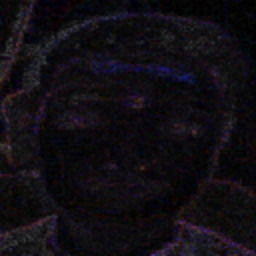

In [20]:
from google.colab import files
from IPython.display import display

# Upload any image from your system
uploaded = files.upload()

# Take the first uploaded file name
img_path = list(uploaded.keys())[0]
print("Testing on:", img_path)

from src.predict_single import predict
label, prob, ela_img = predict(img_path)
print(f"Prediction: {label}, probability={prob:.4f}")

# Show ELA image
display(ela_img.resize((256, 256)))

In [21]:
import gradio as gr
import numpy as np
import tensorflow as tf
from PIL import Image

from src.preprocess_ela import convert_to_ela_image
from src.model_def import IMAGE_SIZE

# 🔸 Load trained model for inference only (no compile, no metrics)
model = tf.keras.models.load_model("models/forgery_cnn_best.h5", compile=False)

def classify_image(input_image):
    """
    input_image: numpy array (H, W, 3) from Gradio
    """
    # Convert to PIL and save a temporary file
    pil_img = Image.fromarray(input_image).convert("RGB")
    temp_path = "temp_input.jpg"
    pil_img.save(temp_path)

    # Convert to ELA
    ela_image = convert_to_ela_image(temp_path)
    ela_resized = ela_image.resize(IMAGE_SIZE)

    # Prepare for model
    x = np.array(ela_resized).astype("float32")
    x = np.expand_dims(x, axis=0)

    # Predict
    prob = model.predict(x)[0][0]
    forged_prob = float(prob)
    authentic_prob = float(1 - prob)

    return {"Authentic": authentic_prob, "Forged": forged_prob}, ela_resized

demo = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="numpy", label="Upload an image"),
    outputs=[
        gr.Label(num_top_classes=2, label="Prediction"),
        gr.Image(type="pil", label="ELA Representation")
    ],
    title="Image Forgery Detection (ELA + CNN)",
    description="""
    <b>Team Members:</b><br>
    1. Loknaath P (Reg No: 212223240080)<br>
    2. Lokhnath J (Reg No: 212223240079)<br>
    <br>
    Upload an image. The model converts it to its Error Level Analysis (ELA) version and predicts whether it is Authentic or Forged.
    """,
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0e6cacad42b0cd2643.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [22]:
import os, shutil

os.makedirs("space_app", exist_ok=True)

# Copy model
shutil.copy("models/forgery_cnn_best.h5", "space_app/forgery_cnn_best.h5")

# Copy helper scripts
shutil.copy("src/preprocess_ela.py", "space_app/preprocess_ela.py")
shutil.copy("src/model_def.py", "space_app/model_def.py")

os.listdir("space_app")

['preprocess_ela.py', 'forgery_cnn_best.h5', 'model_def.py']

In [23]:
%%writefile space_app/app.py
import gradio as gr
import numpy as np
import tensorflow as tf
from PIL import Image

from preprocess_ela import convert_to_ela_image
from model_def import IMAGE_SIZE, build_forgery_model

# Load model (inference only)
model = tf.keras.models.load_model("forgery_cnn_best.h5", compile=False)

def classify_image(input_image):
    """
    input_image: numpy array (H, W, 3)
    """
    pil_img = Image.fromarray(input_image).convert("RGB")
    temp_path = "temp_input.jpg"
    pil_img.save(temp_path)

    ela_image = convert_to_ela_image(temp_path)
    ela_resized = ela_image.resize(IMAGE_SIZE)

    x = np.array(ela_resized).astype("float32")
    x = np.expand_dims(x, axis=0)

    prob = model.predict(x)[0][0]
    forged_prob = float(prob)
    authentic_prob = float(1 - prob)

    return {"Authentic": authentic_prob, "Forged": forged_prob}, ela_resized

demo = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="numpy", label="Upload an image"),
    outputs=[
        gr.Label(num_top_classes=2, label="Prediction"),
        gr.Image(type="pil", label="ELA Representation")
    ],
    title="Image Forgery Detection (ELA + CNN)",
    description="""
    <b>Team Members:</b><br>
    1. Loknaath P (Reg No: 212223240080)<br>
    2. Lokhnath J (Reg No: 212223240079)<br>
    <br>
    Upload an image. The model converts it to its Error Level Analysis (ELA) version and predicts whether it is Authentic or Forged.
    """,
)

if __name__ == "__main__":
    demo.launch()


Writing space_app/app.py


In [24]:
%%writefile space_app/requirements.txt
gradio
tensorflow
numpy
pillow

Writing space_app/requirements.txt


In [25]:
import shutil

shutil.make_archive("space_app_bundle", "zip", "space_app")

'/content/space_app_bundle.zip'

In [26]:
!cp -r src /content/drive/MyDrive/IMAGE_FORGERY_DETECTION
!cp -r models /content/drive/MyDrive/IMAGE_FORGERY_DETECTION
!cp -r data_processed /content/drive/MyDrive/IMAGE_FORGERY_DETECTION
!cp -r data_raw /content/drive/MyDrive/IMAGE_FORGERY_DETECTION
!cp -r space_app /content/drive/MyDrive/IMAGE_FORGERY_DETECTION
